In [1]:
import sys
import os
import toml

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchdata import datapipes as DataPipe

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

import numpy as np
import scipy.optimize as SciOpt
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from tqdm.notebook import tqdm
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

sys.path.append(os.path.join(sys.path[0], '../..'))

from data.io import Reader
from model.kcost import KCostModel
from data.kcost_dataset import EndureDataPipeGenerator
from model.tierlevelcost import TierLevelCost
from lsm.lsmtype import Policy
from jobs.train import TrainJob
import lsm.cost as CostFunc

In [2]:
config = Reader.read_config('../../endure.toml')

In [3]:
model_path = '/data/models/qcost-12-01/'
config_model = Reader.read_config(os.path.join(model_path, 'config.toml'))
ONE_MIB_BITS = 1024 * 1024 * 8
T_UPPER_LIM = config_model['lsm']['size_ratio']['max']
T_LOWER_LIM = config_model['lsm']['size_ratio']['min']
H_UPPER_LIM = config_model['lsm']['bits_per_elem']['max']
MAX_LEVELS = config_model['lsm']['max_levels']

dpg = EndureDataPipeGenerator(config_model)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


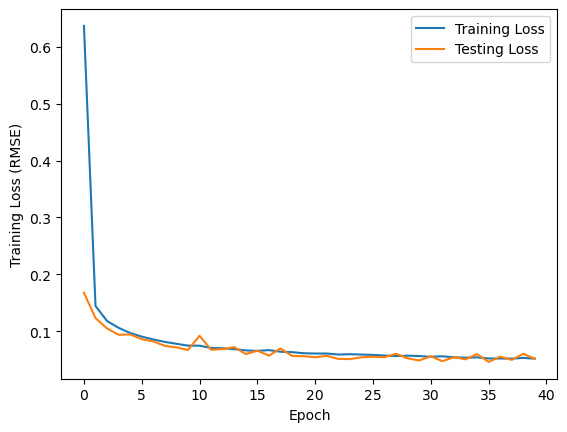

In [4]:
losses = pd.read_csv(os.path.join(model_path, 'losses.csv'))
fig, ax = plt.subplots()
ax.plot(losses['epoch'], losses['train_loss'], label='Training Loss')
ax.plot(losses['epoch'], losses['test_loss'], label='Testing Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel(f'Training Loss ({config_model["train"]["loss_fn"]})')
_ = ax.legend()

In [5]:
tj = TrainJob(config_model)
model = tj._build_model()
# fname = os.path.join(model_path, 'checkpoints/epoch_20.checkpoint')
fname = os.path.join(model_path, 'best.model')
model_data = torch.load(fname, map_location=torch.device('cpu'))
model_params = model_data['model_state_dict'] if fname.endswith('checkpoint') else model_data
load_status = model.load_state_dict(model_params)
model.eval()
load_status

<All keys matched successfully>

In [6]:
cf = CostFunc.EndureQFixedCost(**config_model['system'])
def cost_func_objective(args, wl):
    h, T, Q = args[0], args[1], args[2]
    z0, z1, q, w = wl['z0'], wl['z1'], wl['q'], wl['w']
    return cf.calc_cost(h, T, Q, z0, z1, q, w)

def l2_norm(a, b):
    return np.linalg.norm((a, b), 2)

def create_pairs(T, Q):
    t_frac = T - np.floor(T)
    q_frac = Q - np.floor(Q)
    norms = (l2_norm(1 - t_frac, 1 - q_frac),
             l2_norm(1 - t_frac, q_frac),
             l2_norm(t_frac, 1 - q_frac),
             l2_norm(t_frac, q_frac))
    normalizer = sum(norms)
    pairs = [[np.floor(T), np.floor(Q), norms[0] / normalizer],
             [np.floor(T), np.ceil(Q), norms[1] / normalizer],
             [np.ceil(T), np.floor(Q), norms[2] / normalizer],
             [np.ceil(T), np.ceil(Q), norms[3] / normalizer]]
    # for idx, (t, q, norm) in enumerate(pairs):
    #     if t <= T_LOWER_LIM:
    #         pairs[idx][0] = T_LOWER_LIM
    #     if t >= T_UPPER_LIM:
    #         pairs[idx][0] = T_UPPER_LIM
    #     if q >= T_UPPER_LIM - 1:
    #         pairs[idx][1] = T_UPPER_LIM - 1
    #     if t <= T_UPPER_LIM - 1:
    #         pairs[idx][1] = T_LOWER_LIM - 1
    return pairs

def cost_func_learned_eval(args, wl):
    h, T, Q = args[0], args[1], args[2]
    z0, z1, q, w = wl['z0'], wl['z1'], wl['q'], wl['w']
    row = [0, 0, 0, 0, h, z0, z1, q, w, T, Q]
    _, inputs = dpg._process_row(row)
    inputs = torch.from_numpy(inputs.reshape(1, -1))
    with torch.no_grad():
        pred = model(inputs)
        pred = pred.sum().item() 
    return pred

def cost_func_learned(args, wl):
    h, T, Q = args[0], args[1], args[2]
    pairs = create_pairs(T, Q)
    val = 0
    for (t_prime, q_prime, frac) in pairs:
        val += frac * cost_func_learned_eval([h, t_prime, q_prime], wl)
    return val

In [7]:
def optimize(func=None, h_initial=9., T_initial=5., Q_initial=3., eps=1e-6, display=False):
    h_bounds = (0, H_UPPER_LIM)
    T_bounds = (T_LOWER_LIM, T_UPPER_LIM)
    Q_bounds = (T_LOWER_LIM - 1, T_UPPER_LIM - 1)

    bounds = [h_bounds, T_bounds, Q_bounds]
    min_cost = np.inf
    design = {}
    minimizer_kwargs = {
        'method' : 'SLSQP',
        'bounds' : bounds,
        'options': {'ftol': 1e-9, 'eps': eps, 'disp': display}}
    x0 = np.array([h_initial, T_initial, Q_initial])
    
    sol = SciOpt.minimize(
        fun=func,
        x0=x0,
        **minimizer_kwargs
    )
    return sol

In [8]:
analytical_sol = optimize(
    func=lambda x: cost_func_objective(x, config_model['workloads'][0]),
    eps=1e-4)
analytical_sol

     fun: 2.8272110972604314
     jac: array([-2.10591544e-07, -3.21631610e-07,  1.76478832e-06])
 message: 'Optimization terminated successfully'
    nfev: 72
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([3.2998929 , 6.184048  , 1.06928004])

In [9]:
learned_sol = optimize(
    func=lambda x: cost_func_learned(x, config_model['workloads'][0]),
    eps=1e-4)
learned_sol

     fun: 3.391979435822768
     jac: array([ 1.76211346e-02, -9.00843844e-06,  8.06259480e-02])
 message: 'Optimization terminated successfully'
    nfev: 368
     nit: 62
    njev: 62
  status: 0
 success: True
       x: array([ 4.60463575, 12.6438398 ,  2.997627  ])

In [10]:
p_args = [[analytical_sol.x[0], np.floor(analytical_sol.x[1]), np.floor(analytical_sol.x[2])],
          [analytical_sol.x[0], np.floor(analytical_sol.x[1]), np.ceil(analytical_sol.x[2])],
          [analytical_sol.x[0], np.ceil(analytical_sol.x[1]), np.floor(analytical_sol.x[2])],
          [analytical_sol.x[0], np.ceil(analytical_sol.x[1]), np.ceil(analytical_sol.x[2])],]
print(f'Analytical Output: {analytical_sol.x}-> {cost_func_objective(analytical_sol.x, config_model["workloads"][0])}')
for arg in p_args:
    print(f'Analytical Rounded: {arg}-> {cost_func_objective(arg, config_model["workloads"][0])}')
print(f'Learned Output: {learned_sol.x}-> {cost_func_objective(learned_sol.x, config_model["workloads"][0])}')
lsol = learned_sol.x
lsol[1] = np.ceil(lsol[1])
print(f'Learned Rounded: {lsol}-> {cost_func_objective(lsol, config_model["workloads"][0])}')

Analytical Output: [3.2998929  6.184048   1.06928004]-> 2.8272110972604314
Analytical Rounded: [3.2998929034371765, 6.0, 1.0]-> 2.830347611445995
Analytical Rounded: [3.2998929034371765, 6.0, 2.0]-> 3.3341556610411462
Analytical Rounded: [3.2998929034371765, 7.0, 1.0]-> 2.854765402987561
Analytical Rounded: [3.2998929034371765, 7.0, 2.0]-> 3.2070238282069132
Learned Output: [ 4.60463575 12.6438398   2.997627  ]-> 3.44563327850141
Learned Rounded: [ 4.60463575 13.          2.997627  ]-> 3.4328255838459754


In [52]:
def gen_single_data(idx=0):
    workload = config_model['workloads'][idx]
    df = []
    h_fixed = 2
    t_fixed = 30
    q_fixed = 1
    for val in tqdm(np.arange(2, 50, 1)):
        x = [h_fixed, val, q_fixed]
        df.append({
            'x': val,
            'learned': cost_func_learned_eval(x, workload),
            'analytical': cost_func_objective(x, workload),
        })
    return pd.DataFrame(df)

idx = 2
df = gen_single_data(idx)

  0%|          | 0/48 [00:00<?, ?it/s]

{'id': 2, 'z0': 0.01, 'z1': 0.97, 'q': 0.01, 'w': 0.01}

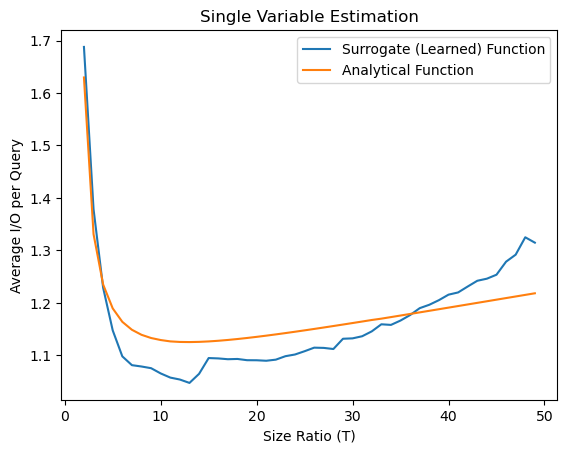

In [53]:
x = df['x']
y_learned = df['learned']
y_analytical = df['analytical']

fig, ax = plt.subplots()
ax.plot(x, y_learned, label='Surrogate (Learned) Function')
ax.plot(x, y_analytical, label='Analytical Function')
ax.set_xlabel('Size Ratio (T)')
ax.set_ylabel('Average I/O per Query')
ax.set_title('Single Variable Estimation')
ax.legend()
workload = config_model['workloads'][idx]
workload

In [13]:
def gen_hist_data(workload):
    df = []
    for h_p in tqdm(np.arange(0, H_UPPER_LIM, 0.5), leave=False):
        for T_p in np.arange(T_LOWER_LIM, T_UPPER_LIM, 1):
            for Q_p in range(T_LOWER_LIM - 1, T_p, 1):
                x = [h_p, T_p, Q_p]
                df.append({
                    'workload': workload,
                    'h': h_p,
                    'T': T_p,
                    'Q': Q_p,
                    'learned': cost_func_learned_eval(x, workload),
                    'analytical': cost_func_objective(x, workload),})
    return pd.DataFrame(df)

  0%|          | 0/19 [00:00<?, ?it/s]

{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, 'w': 0.25}

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


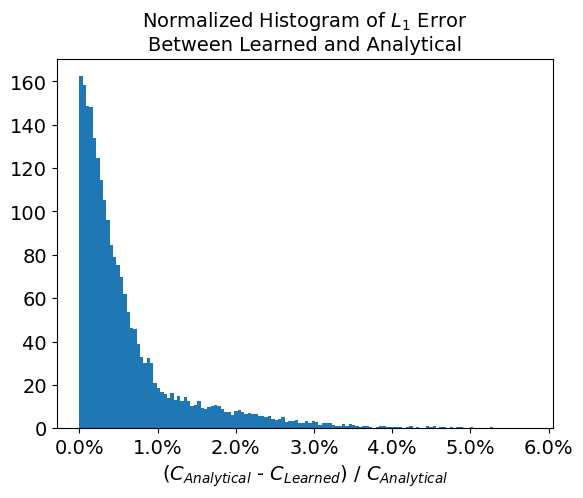

In [14]:
idx = 0
df = gen_hist_data(config_model['workloads'][idx])

df['delta'] = abs((df['analytical'] - df['learned']) / df['analytical'])
n, bins, patches = plt.hist(x=df['delta'], bins='auto', density=True)
plt.xlabel('($C_{Analytical}$ - $C_{Learned}$) / $C_{Analytical}$',
           fontsize=14)
plt.title('Normalized Histogram of $L_1$ Error\nBetween Learned and Analytical',
          fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
config_model['workloads'][idx]

In [15]:
df.sort_values(by='delta')

,workload,h,T,Q,learned,analytical,delta
22183,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",9.00,46,26,16.09,16.09,0.00
5122,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",2.00,30,13,9.40,9.40,0.00
2049,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",0.50,43,13,10.75,10.75,0.00
6909,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",2.50,46,40,23.75,23.75,0.00
823,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",0.00,42,4,4.86,4.86,0.00
...,...,...,...,...,...,...,...
67,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",0.00,13,2,3.76,3.56,0.05
1255,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",0.50,14,2,3.58,3.40,0.05
1243,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",0.50,13,2,3.59,3.40,0.06
92,"{'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, '...",0.00,15,2,3.76,3.56,0.06


In [16]:
dfs = []
for wl in tqdm(config_model['workloads']):
    dfs.append(gen_hist_data(wl))

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

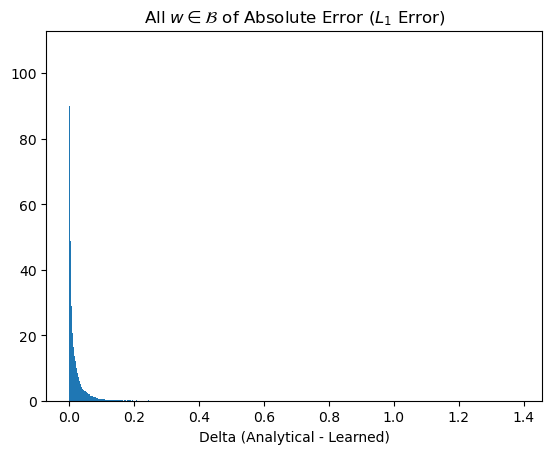

In [17]:
df = pd.concat(dfs)

df['delta'] = abs((df['analytical'] - df['learned']) / df['analytical'])
n, bins, patches = plt.hist(x=df['delta'], bins='auto', density=True)
plt.xlabel('Delta (Analytical - Learned)')
plt.title('All $w \in \mathcal{B}$ of Absolute Error ($L_1$ Error)')
None

In [18]:
df.sort_values(by='delta')

,workload,h,T,Q,learned,analytical,delta
16466,"{'id': 14, 'z0': 0.01, 'z1': 0.33, 'q': 0.33, ...",7.00,3,2,6.30,6.30,0.00
13428,"{'id': 8, 'z0': 0.01, 'z1': 0.49, 'q': 0.49, '...",5.50,32,28,30.79,30.79,0.00
16148,"{'id': 2, 'z0': 0.01, 'z1': 0.97, 'q': 0.01, '...",6.50,42,41,2.81,2.81,0.00
11554,"{'id': 8, 'z0': 0.01, 'z1': 0.49, 'q': 0.49, '...",4.50,45,25,24.80,24.80,0.00
13123,"{'id': 14, 'z0': 0.01, 'z1': 0.33, 'q': 0.33, ...",5.50,20,17,15.07,15.07,0.00
...,...,...,...,...,...,...,...
21259,"{'id': 1, 'z0': 0.97, 'z1': 0.01, 'q': 0.01, '...",9.00,15,1,0.42,0.18,1.28
20047,"{'id': 1, 'z0': 0.97, 'z1': 0.01, 'q': 0.01, '...",8.50,12,1,0.39,0.17,1.30
21223,"{'id': 1, 'z0': 0.97, 'z1': 0.01, 'q': 0.01, '...",9.00,12,1,0.40,0.17,1.33
21234,"{'id': 1, 'z0': 0.97, 'z1': 0.01, 'q': 0.01, '...",9.00,13,1,0.42,0.18,1.37


In [19]:
def generate_configurations():
    df = []
    for wl in tqdm(config_model['workloads']):
        z0, z1, q, w = (wl['z0'], wl['z1'], wl['q'], wl['w'])
        learn = optimize(func=lambda x: cost_func_learned(x, wl),
                         eps=1e-3)
        hand = optimize(func=lambda x: cost_func_objective(x, wl),
                        eps=1e-3)
        df.append({
            'id': wl['id'],
            'wl': wl,
            'learn': learn,
            'hand': hand,
            'delta': cost_func_objective(hand.x, wl) - cost_func_objective(learn.x, wl)
        })
    return pd.DataFrame(df)

df = generate_configurations()

  0%|          | 0/15 [00:00<?, ?it/s]

In [40]:
def sample_workload(dimensions: int=4) -> list:
    # See stackoverflow thread for why the simple solution is not uniform
    # https://stackoverflow.com/questions/8064629/random-numbers-that-add-to-100-matlab
    workload = list(np.random.rand(dimensions - 1)) + [0, 1]
    workload.sort()
    return [b - a for a, b in zip(workload, workload[1:])]

def gen_workload_heat(samples=10):
    df = []
    for _ in tqdm(range(samples)):
        z0, z1, q, w = sample_workload(dimensions=4)
        wl = {'z0': z0, 'z1': z1, 'q': q, 'w': w}
        learn = optimize(func=lambda x: cost_func_learned(x, wl),
                         eps=1e-2, display=False)
        hand = optimize(func=lambda x: cost_func_objective(x, wl),
                        eps=1e-6, display=False)
        cost_learn = cost_func_objective(learn.x, wl)
        cost_hand = cost_func_objective(hand.x, wl)
        df.append({
            'z0': wl['z0'],
            'z1': wl['z1'],
            'q': wl['q'],
            'w': wl['w'],
            'learn_status': learn['status'],
            'learn_h': learn.x[0],
            'learn_T': learn.x[1],
            'learn_Q': learn.x[2],
            'hand_status': hand['status'],
            'hand_h': hand.x[0],
            'hand_T': hand.x[1],
            'hand_Q': hand.x[2],
            'cost_learn': cost_learn,
            'cost_hand': cost_hand,
        })
    return pd.DataFrame(df)

In [41]:
df = gen_workload_heat(100)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Frequency of Error: Positive is Better')

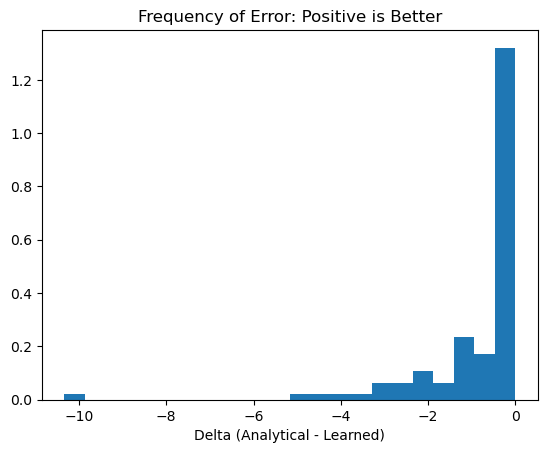

In [42]:
df['delta'] = (df['cost_hand'] - df['cost_learn'])
n, bins, patches = plt.hist(x=df['delta'], bins='auto', density=True)
plt.xlabel('Delta (Analytical - Learned)')
plt.title('Frequency of Error: Positive is Better')

In [43]:
df.sort_values(by='delta')

,z0,z1,q,w,learn_status,learn_h,learn_T,learn_Q,hand_status,hand_h,hand_T,hand_Q,cost_learn,cost_hand,delta
55,0.13,0.02,0.22,0.62,0,2.16,50.00,1.00,0,2.27,7.23,2.00,14.33,4.00,-10.33
5,0.07,0.18,0.69,0.07,0,0.00,2.00,1.00,0,0.48,21.27,1.00,7.67,2.54,-5.13
18,0.08,0.14,0.57,0.22,9,1.55,10.04,3.99,0,0.49,9.14,1.00,7.78,3.49,-4.29
48,0.19,0.22,0.56,0.02,0,3.49,8.87,2.99,0,2.67,35.89,1.00,6.02,1.83,-4.20
15,0.08,0.36,0.45,0.11,9,3.09,6.60,2.99,0,1.41,12.07,1.00,5.92,2.56,-3.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.16,0.20,0.10,0.54,0,4.54,7.08,3.00,0,4.36,8.02,2.94,2.93,2.92,-0.01
73,0.10,0.62,0.16,0.12,0,2.54,7.98,1.00,0,3.25,6.78,1.00,2.07,2.06,-0.01
95,0.37,0.05,0.17,0.41,0,4.77,7.92,2.00,0,4.34,7.02,1.83,2.99,2.98,-0.01
67,0.02,0.06,0.25,0.66,0,0.29,7.90,2.00,0,0.05,7.13,1.92,4.22,4.21,-0.01


In [44]:
# idx = 485
# df.iloc[idx].wl

In [45]:
# df_tmp = gen_hist_data(df.iloc[idx].wl)

# df_tmp['delta'] = abs((df_tmp['analytical'] - df_tmp['learned']) / df_tmp['analytical'])
# n, bins, patches = plt.hist(x=df_tmp['delta'], bins='auto', density=True)
# plt.xlabel('Delta (Analytical - Learned) / Analytical')
# plt.title('Frequency of Absolute Error ($L_1$ Error)')
# df.iloc[idx].wl

In [46]:
# df_tmp

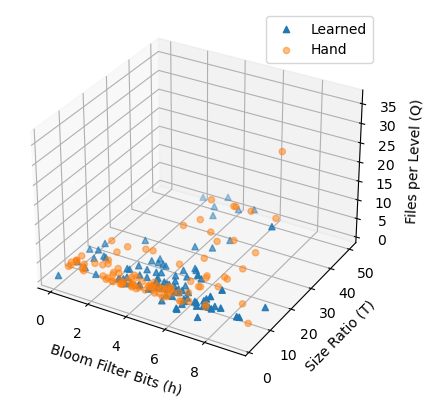

In [47]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(xs=df['learn_h'], ys=df['learn_T'], zs=df['learn_Q'], marker='^', label='Learned')
ax.scatter(xs=df['hand_h'], ys=df['hand_T'], zs=df['hand_Q'], marker='o', label='Hand', alpha=0.5)
ax.set_xlabel('Bloom Filter Bits (h)')
ax.set_ylabel('Size Ratio (T)')
ax.set_zlabel('Files per Level (Q)')
ax.legend()
plt.show()